In [1]:
from qiskit.circuit import QuantumCircuit, Parameter, ParameterVector, Gate
from typing import Union
from qiskit import assemble
from qiskit.circuit.library import TwoLocal


In [25]:
# We will implement the efficientSU2 ansatz
def quanvolutionESU2(N_dims, gates=['rx', 'rz'], reps=1, entanglement='circular'):
    
    # Function to apply rotation gates to all of our qubits
    def rotation(gate, start):
        qc = QuantumCircuit(N_dims, name=gate)
        for i in range(N_dims):
            if gate == 'rx':
                qc.rx(parameters[start+i], i)
            if gate == 'ry':
                qc.ry(parameters[start+i], i)
            if gate == 'rz':
                qc.rz(parameters[start+i], i)
        return qc
    
    # Function apply the entanglement
    def entanglement(type=entanglement):
        qc = QuantumCircuit(N_dims, name=type)
        if (type == "circular"):
            qc.cx(N_dims-1, 0)
            for i in range(N_dims-1):
                target = i + 1
                qc.cx(i, target)
        if (type == "linear"):
            for i in range(N_dims - 1):
                target = i + 1
                qc.cx(i, target)
        if (type == "full"):
            for i in range(N_dims):
                for j in range(N_dims):
                    if (i != j):
                        qc.cx(i, j)
        return qc
    
    # Calculate the number of parameters we will need
    num_params = 2*len(gates)*N_dims*reps
    parameters = ParameterVector('θ', num_params)
    qc = QuantumCircuit(N_dims, name="EfficientSU2")
    start = 0
    
    for i in range(reps):
        for gate in gates:
            qc.compose(rotation(gate, start), range(N_dims), inplace=True)
            start += N_dims

        qc.compose(entanglement(), range(N_dims), inplace=True)
        
        if (reps == 1 or i == reps-1):
            qc.barrier()
            for gate in gates:
                qc.compose(rotation(gate, start), range(N_dims), inplace=True)
                start += N_dims
        qc.barrier()
    
    return qc

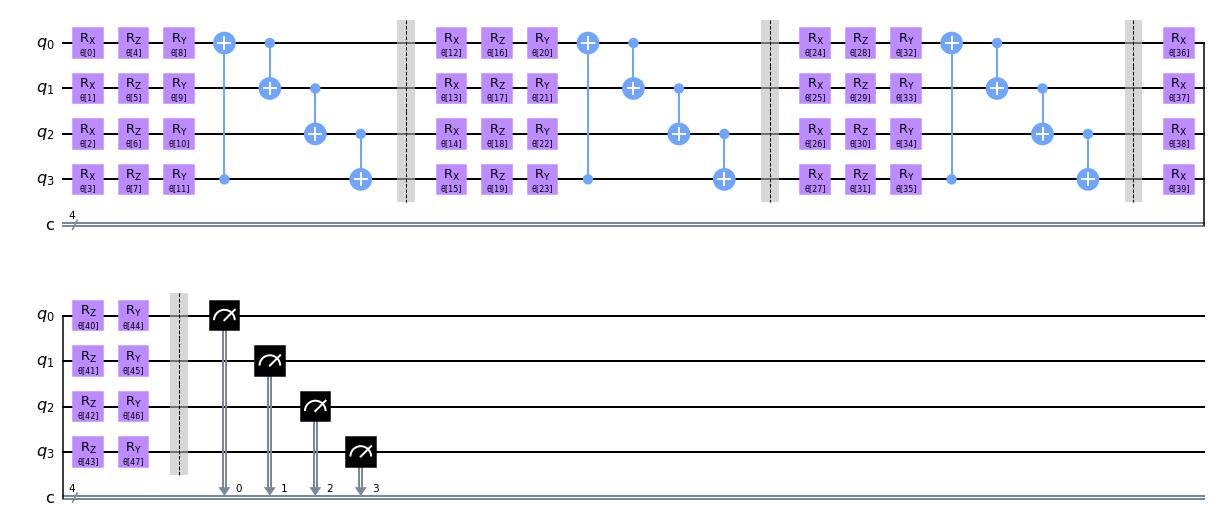

In [26]:
def randomLayer(numQbits, gates=['rx', 'rz', 'ry'], entanglement='linear', reps=1, to_gate=True) -> Union[Gate, QuantumCircuit]:
    qc = QuantumCircuit(numQbits)
    qc.compose(quanvolutionESU2(numQbits, gates=gates, entanglement=entanglement, reps=reps), inplace=True)
    return qc.to_gate(label="Random Layer") if to_gate else qc

n = 4
qc = QuantumCircuit(n,n)
qc.compose(randomLayer(n, reps=3, to_gate=False, entanglement='circular'), inplace=True)
qc.measure(range(n), range(n))
qc.draw('mpl')